# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This study utilizes real-world data obtained from a Portuguese retail bank, covering the period from May 2008 to June 2013, comprising a total of 52,944 phone contact records. The dataset is imbalanced, with only 6,557 entries (12.38%) corresponding to successful outcomes.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier  # Added Decision Trees
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn import set_config

import time
import warnings

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/bank-additional-full.csv', sep = ';')

In [115]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [117]:
#check how much data has before modifying it
df.shape

(41188, 21)

In [118]:
#check the amount of Nan values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [119]:
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 12


In [120]:
# Remove duplicates
df = df.drop_duplicates()

In [121]:
#check shape after
df.shape

(41176, 21)

#Understanding the Features
- the data has no nulls values
- There are 10 categorical and 10 numerical values
- Within the Categorical Features we have 3 BINARY features: 'default', 'housing' , 'loan'

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


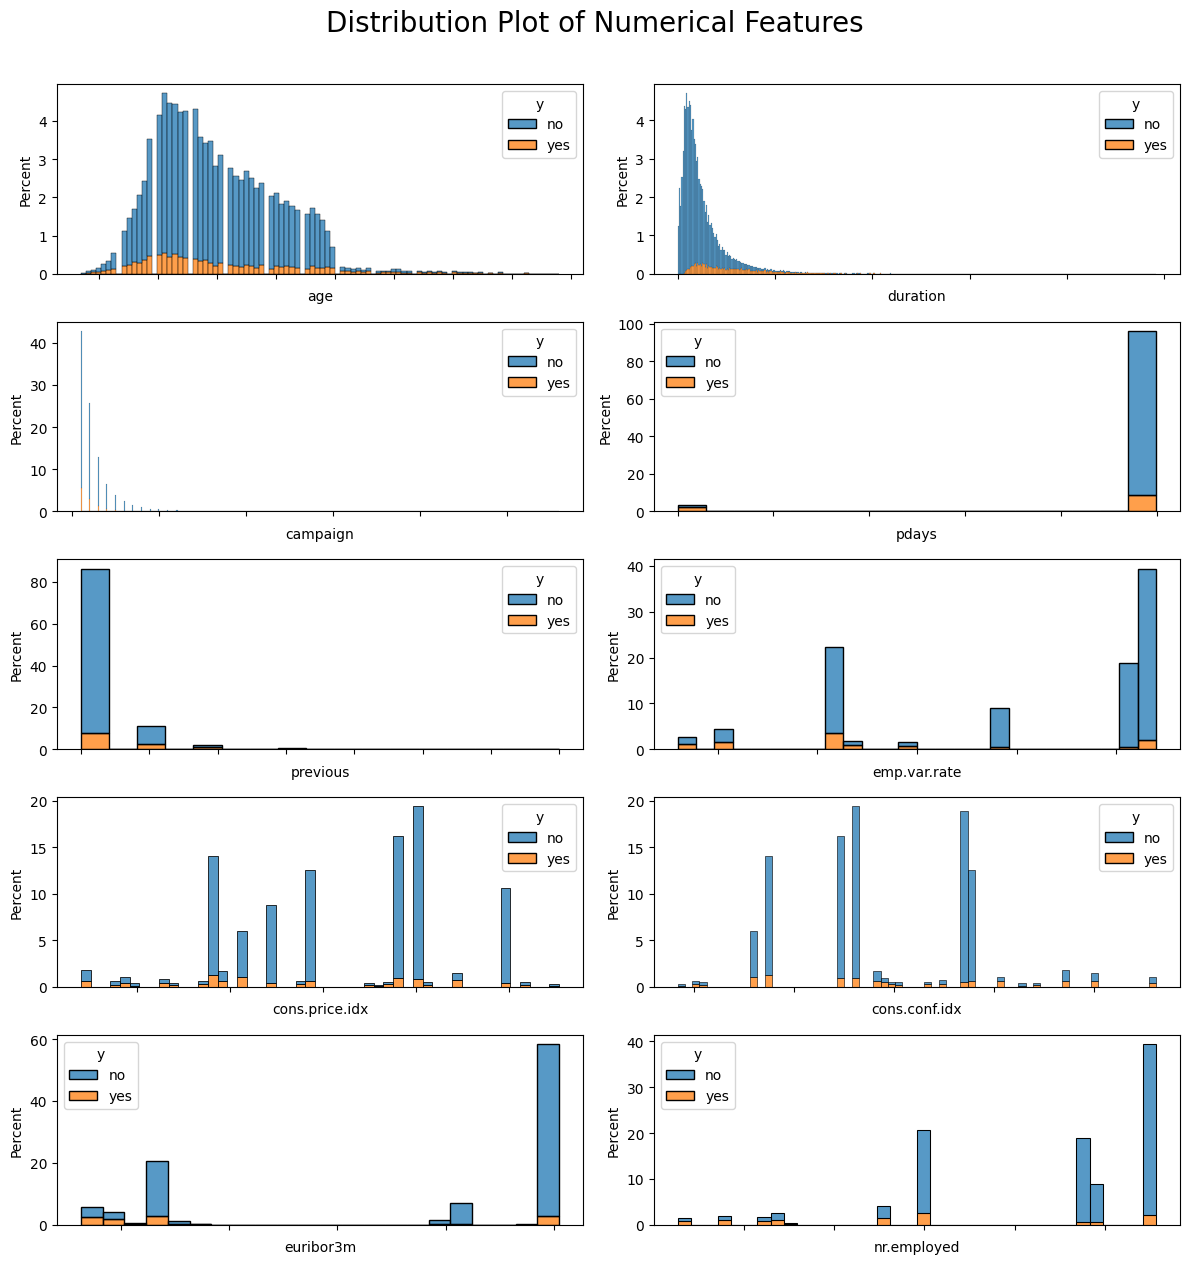

In [122]:
# Distribution Plot of the Numerical features
num_column_lst = []
for icol in df.columns:
    if df[icol].dtypes in ['float64', 'int64']:
        num_column_lst.append(icol)
print(num_column_lst)

fig, axs = plt.subplots(nrows = 5, ncols=2, figsize = (12,12))
for name,ax in zip(num_column_lst,axs.flatten()):
    sns.histplot(data=df,x=name,ax=ax,hue='y',multiple='stack',stat='percent')
    ax.set_xticklabels(ax.get_xticklabels(minor=True,which='minor'),rotation=0,fontsize=50)

fig.tight_layout()
fig.suptitle('Distribution Plot of Numerical Features',y=1.05,fontsize=20)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/images/num_plots.png')

Intprepretation of the numerical plots:

- duration (call length) is the strongest separator: longer calls skew heavily toward yes.

- age: mild trend—conversions slightly higher in middle-to-older ages; very young and very old have lower “yes” share.

- campaign (contacts in this campaign) is extremely right-skewed; most people were contacted once. As campaign increases, the “yes” proportion drops—diminishing returns & fatigue.

- pdays: a huge spike at the “no previous contact” code. Where prior contact exists (lower values), “yes” is more common—warm leads convert better.

- previous (prior contacts) mostly zero; nonzero values show a somewhat higher “yes” rate but with small counts.


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


/tmp/ipython-input-3183998952.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
/tmp/ipython-input-3183998952.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
/tmp/ipython-input-3183998952.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
/tmp/ipython-input-3183998952.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotati

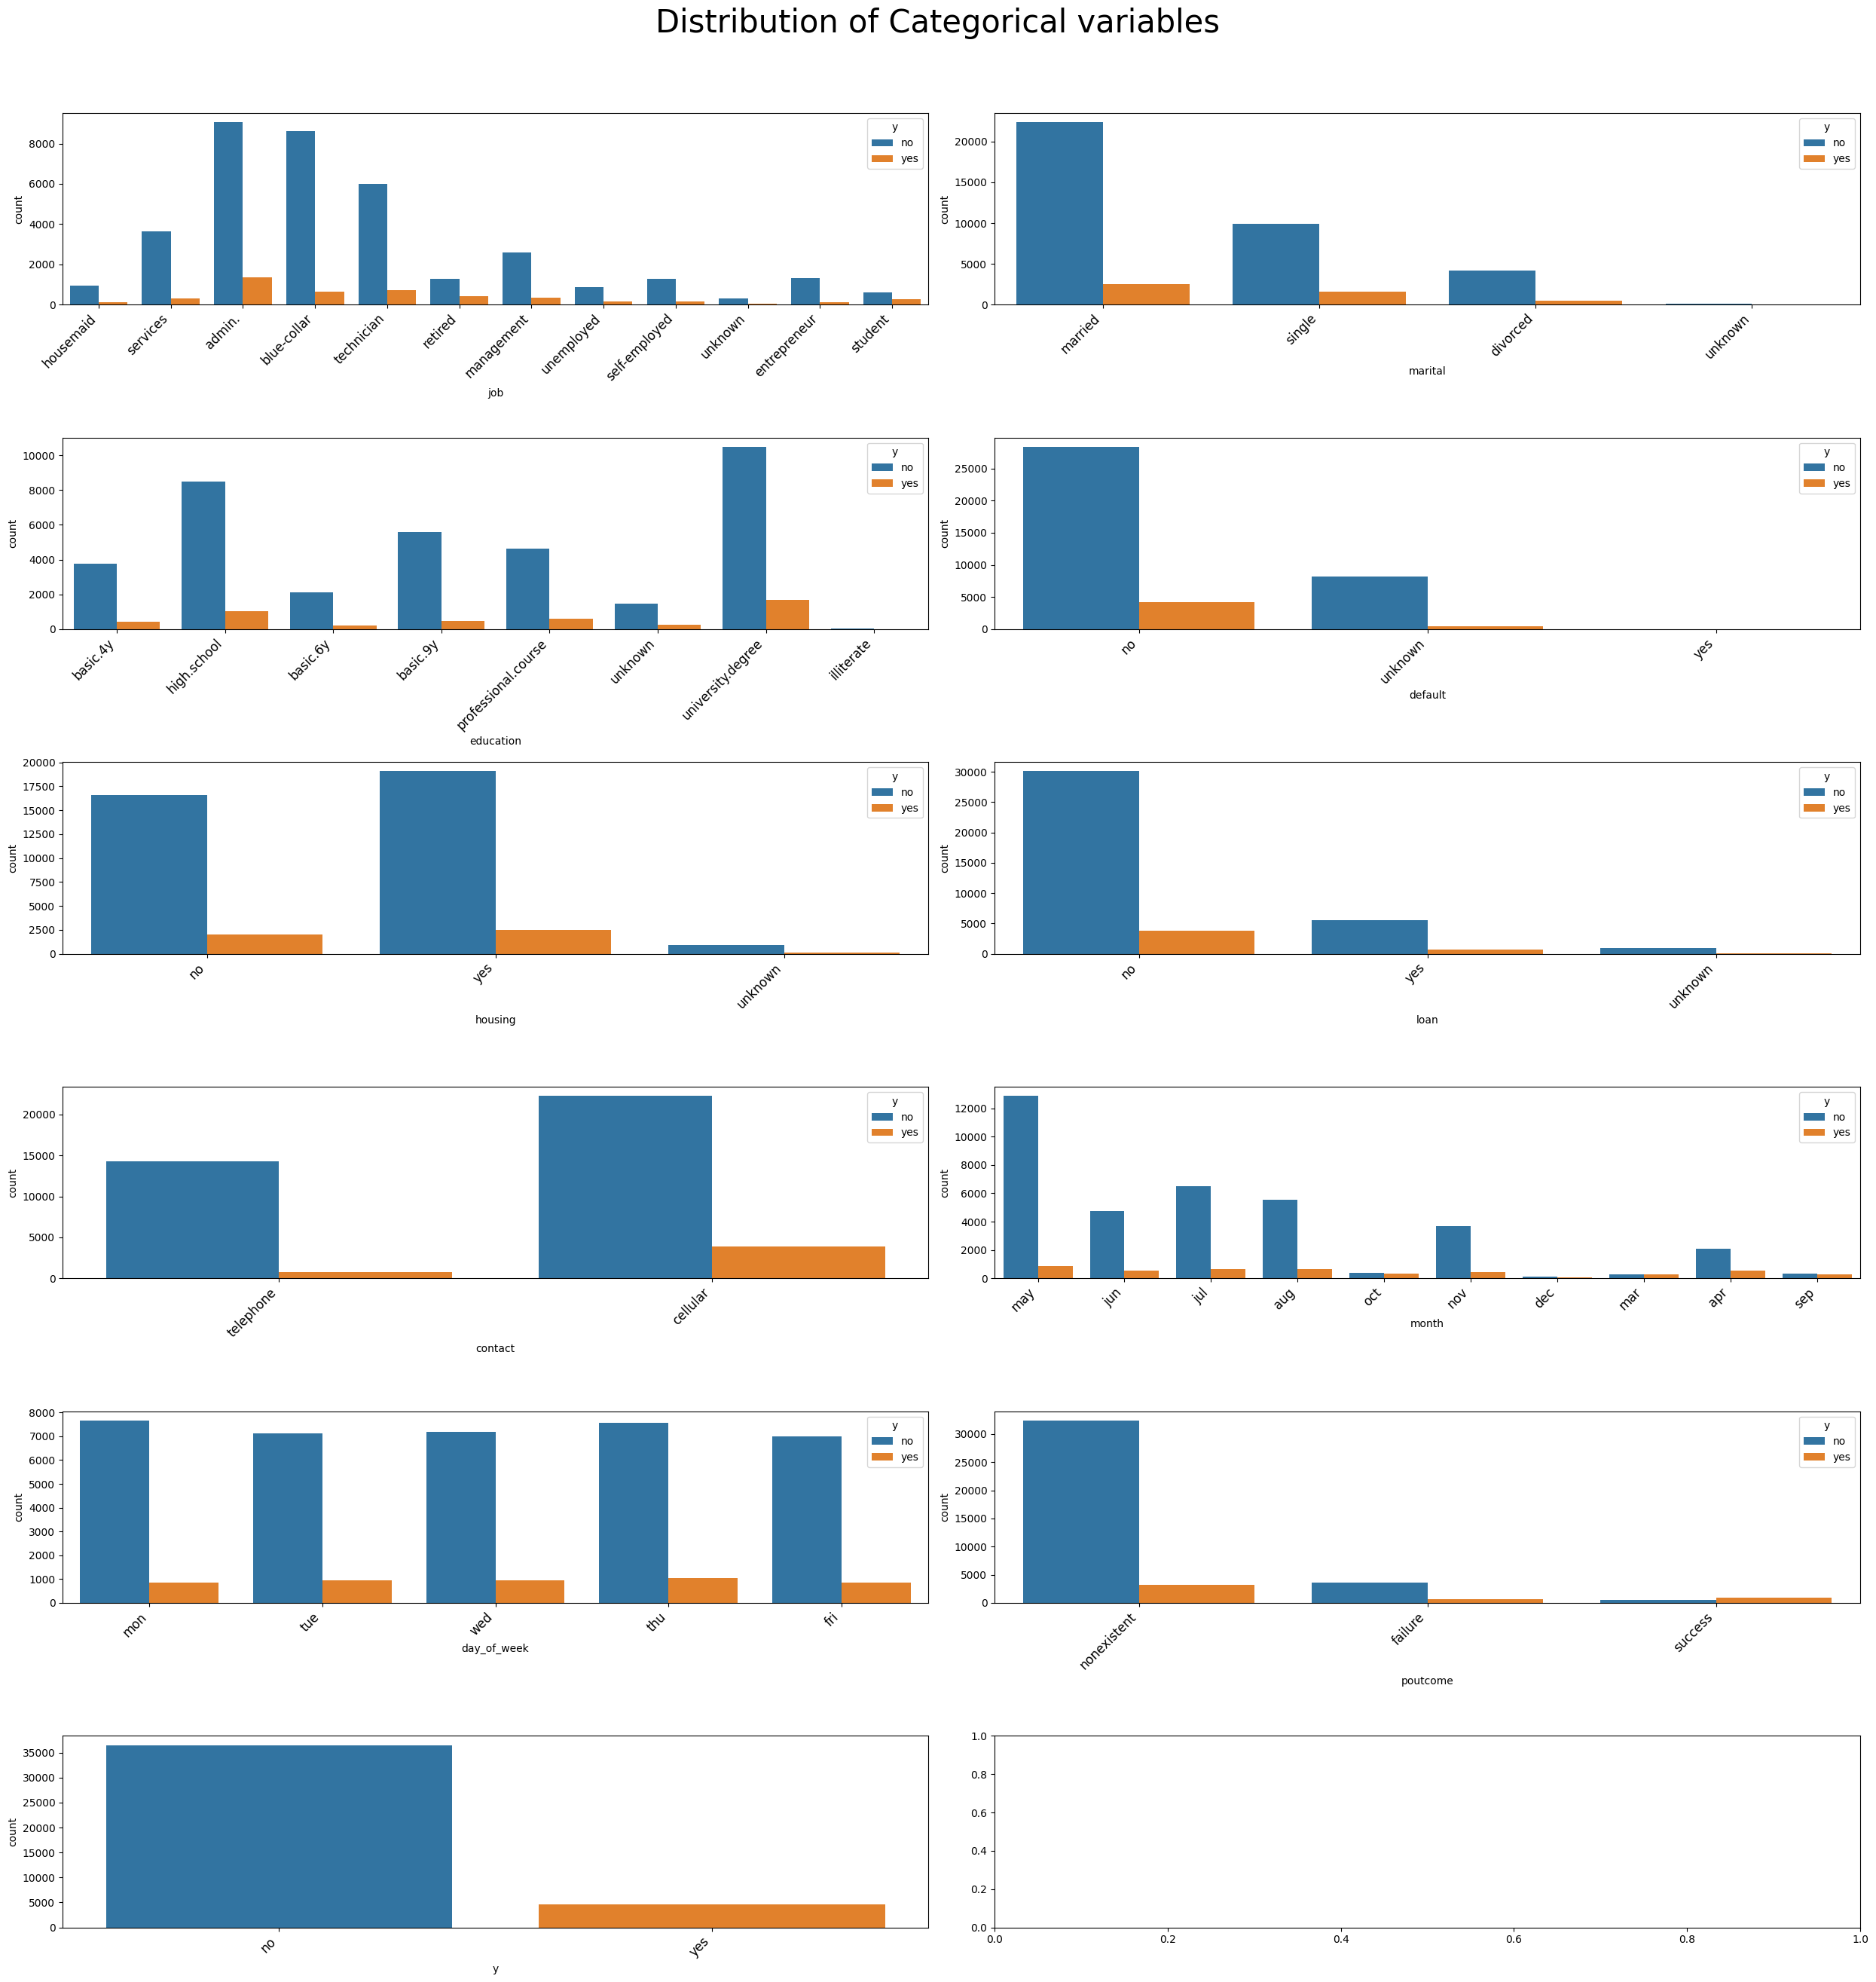

In [123]:
# Distribution of the categorical features
cat_column_lst = []
for icol in df.columns:
    if df[icol].dtypes in ['object']:
        cat_column_lst.append(icol)
print(cat_column_lst)

fig, axs = plt.subplots(nrows = 6, ncols=2, figsize = (25,25))
for name,ax in zip(cat_column_lst,axs.flatten()):
    sns.countplot(data=df,x=name,ax=ax,hue='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)

fig.tight_layout()
fig.suptitle('Distribution of Categorical variables',y=1.05,fontsize=30)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/images/cat_plots.png')

Intprepretation of the categorical plots:

- contact: cellular dominates volume and shows higher raw “yes” counts than telephone—consistent with better reach/engagement.

- month: clear seasonality—spring/summer months (e.g., May–Aug) have more contacts and more “yes” in absolute terms; conversion rate should be checked, but historically some months outperform (often Mar/Oct/Dec vs. May volume—verify with rates).

- day_of_week: fairly uniform; *minor* differences—likely low signal versus other features.

- job: “admin.”, “blue-collar”, and “technician” dominate volume; management/s- elf-employed/student/retired groups often show higher conversion rates despite lower counts—worth segment-specific strategies.

- education: secondary is largest group; higher education levels can show slightly better acceptance—again, check rates, not just counts.

- marital: married dominates volume; singles sometimes show modestly higher uptake—needs rate analysis.

- default: almost all “no”; little signal (rare positives).

- housing/loan: customers without these loans tend to accept slightly more—possibly more disposable income or interest in savings.


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Objective: The objective of the dataset in bank-additional-full.csv is to predict whether a client will subscribe to a term deposit (y column), based on data collected from a Portuguese bank’s marketing campaigns.

To do so, we will compare the classification methods of:

- K-nearest neighbors (KNN)
- Logistic Regression (LR)
- Decision Trees (DT)
- Support Vector Machines (SVM)


Prioritize warm leads: low pdays, non-“nonexistent” poutcome, and nonzero previous show better outcomes.

Cap outreach attempts: rising campaign counts correlate with lower success; implement contact ceilings and earlier stop rules.

Channel strategy: lean into cellular; de-emphasize landline where ROI is weak.

Segment playbooks: tailor offers/scripts for management/self-employed/retired segments and possibly higher-education segments—test for higher lift.

Seasonality planning: budget and staffing should reflect months with historically higher performance; confirm with conversion rates.

Modeling caution: build two models—(1) pre-call model (exclude duration) for targeting, and (2) post-call model (may include duration) for end-of-call next-best-action.

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [125]:
print(df['y'].unique())

['no' 'yes']


In [126]:
#converting the ['y'] to string
df['y'] = df['y'].astype(str).str.strip().str.lower()
print(df['y'].unique())  # Should show 'yes' and 'no'

['no' 'yes']


In [127]:
# Convert 'yes' to 1 and 'no' to 0 in the target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [128]:
df['y'].value_counts()

,count
y,
0,36537
1,4639


In [129]:
df['y'].isna().sum()

np.int64(0)

In [130]:
bank_features = {'age', 'job', 'marital', 'education', 'default', 'housing', 'loan'}

target_column = 'y'
# Convert the set to a list and add the target column name
selected_columns = list(bank_features) + [target_column]

bank_df = df[selected_columns]

#one hot-encoding
df_encoded = pd.get_dummies(bank_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'], drop_first=True)

#seperate features and target
X = df_encoded.drop(columns='y')
y = df_encoded['y']


In [131]:
#seperate categorical and numerical
categorical_cols = bank_df.select_dtypes(include=['object', 'string']).columns.tolist()
numerical_cols = bank_df.select_dtypes(include=['int64', 'float64', 'Int64', 'Float64']).columns.tolist()

categorical_cols, numerical_cols

(['default', 'loan', 'marital', 'education', 'job', 'housing'], ['age', 'y'])

In [132]:
#create transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        (
          'cat',
            OneHotEncoder(
              handle_unknown='ignore',
              drop='if_binary'
            ),
          categorical_cols
         )
    ])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32940 entries, 12348 to 15798
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            32940 non-null  int64
 1   job_blue-collar                32940 non-null  bool 
 2   job_entrepreneur               32940 non-null  bool 
 3   job_housemaid                  32940 non-null  bool 
 4   job_management                 32940 non-null  bool 
 5   job_retired                    32940 non-null  bool 
 6   job_self-employed              32940 non-null  bool 
 7   job_services                   32940 non-null  bool 
 8   job_student                    32940 non-null  bool 
 9   job_technician                 32940 non-null  bool 
 10  job_unemployed                 32940 non-null  bool 
 11  job_unknown                    32940 non-null  bool 
 12  marital_married                32940 non-null  bool 
 13  marital_single   

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

 Baseline Model gives us a reference point to determine whether more complex models are actually helping. In binary classification (like this case: predicting whether a client subscribes to a term deposit), a common baseline is: Always predicting the majority class

In [135]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline_accuracy = bank_df['y'].value_counts(normalize=True).max()
baseline_accuracy

0.8873372838546726

In [136]:

baseline_model= DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

y_proba = baseline_model.predict_proba(X_test)[:, 1]
baseline_model.score(X_train, y_train)

0.8886460230722526

In [137]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_baseline)
precision = precision_score(y_test, y_pred_baseline, average='binary')
recall = recall_score(y_test, y_pred_baseline, average='binary')
f1 = f1_score(y_test,y_pred_baseline, average='binary')
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred_baseline)

print(f"Model Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Model Accuracy: 0.8821
Confusion Matrix:
 [[7265    0]
 [ 971    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [138]:
results_df = pd.DataFrame({'Baseline_model': [accuracy, precision, recall, f1, roc_auc, pr_auc]},
                          index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC'])
results_df

,Baseline_model
Accuracy,0.882103
Precision,0.000000
Recall,0.000000
F1 Score,0.000000
ROC AUC,0.500000
PR AUC,0.117897


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [139]:
# Preprocessor: One-hot encode categorical, scale numeric
# Redefine categorical and numerical columns based on X_train after one-hot encoding
categorical_cols_encoded = X_train.select_dtypes(include='bool').columns.tolist()
numerical_cols_encoded = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_encoded),
        ('num', StandardScaler(), numerical_cols_encoded)
    ]
)

In [140]:
# Logistic Regression model with class balancing
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Fit the model
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job_blue-collar',
                                                   'job_entrepreneur',
                                                   'job_housemaid',
                                                   'job_management',
                                                   'job_retired',
                                                   'job_self-employed',
                                                   'job_services',
                                                   'job_student',
                                                   'job_technician',
                                                   'job_unemployed',
                                                   'job_unknown',
                                                   'marital_married',
                                                   'marital_single',
                                                   'marital_unknown',
                                                   'educ...
                                                   'education_basic.9y',
                                                   'education_high.school',
                                                   'education_illiterate',
                                                   'education_professional.course',
                                                   'education_university.degree',
                                                   'education_unknown',
                                                   'default_unknown',
                                                   'default_yes',
                                                   'housing_unknown',
                                                   'housing_yes',
                                                   'loan_unknown',
                                                   'loan_yes']),
                                                 ('num', StandardScaler(),
                                                  ['age'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [141]:
# Predictions
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]


### Problem 9: Score the Model

What is the accuracy of your model?

In [142]:
# Evaluate
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'PR AUC': average_precision_score(y_test, y_proba)
}

print("Logiistic Regression")
for k, v in metrics.items():
    print(f"{k:>10} {v:.4f}")

Logiistic Regression
  Accuracy 0.5947
 Precision 0.1702
    Recall 0.6292
  F1 Score 0.2680
   ROC AUC 0.6550
    PR AUC 0.2114


In [143]:
results_df['Logistic_Regression'] = metrics
results_df

,Baseline_model,Logistic_Regression
Accuracy,0.882103,0.594706
Precision,0.000000,0.170242
Recall,0.000000,0.629248
F1 Score,0.000000,0.267982
ROC AUC,0.500000,0.655049
PR AUC,0.117897,0.211385


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [144]:
# Start with your baseline results
results_df = pd.DataFrame({'Baseline_model': [accuracy, precision, recall, f1, roc_auc, pr_auc]},
                          index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC'])

fit_times = {"Baseline_model": None}  # baseline has no training time

In [145]:
# Models to compare
models = {
    "baseline model": DummyClassifier(strategy='most_frequent'),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(kernel="linear", class_weight="balanced", random_state=42)
}

In [146]:

fit_times = {}
new_rows = []

# Train, predict, evaluate for each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(X_test)
    )
    elapsed = time.time() - start_time
    fit_times[name] = None if name.lower().startswith("baseline") else elapsed

    new_rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "PR AUC": average_precision_score(y_test, y_proba),
        "Time (s)": fit_times[name]
    })

# Build DataFrame in one go
results_df = pd.DataFrame(new_rows).set_index("Model")

print("Performance Table:")
print(results_df)

Performance Table:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Model                                                                    
baseline model       0.882103   0.000000  0.000000  0.000000  0.500000   
Logistic Regression  0.594949   0.170153  0.628218  0.267779  0.654997   
KNN                  0.872875   0.350394  0.091658  0.145306  0.576903   
Decision Tree        0.864497   0.289855  0.102987  0.151976  0.594501   
SVM                  0.611705   0.172018  0.601442  0.267522  0.642666   

                       PR AUC    Time (s)  
Model                                      
baseline model       0.117897         NaN  
Logistic Regression  0.211598    8.838233  
KNN                  0.159663   10.505741  
Decision Tree        0.171395    0.176086  
SVM                  0.186412  183.777955  


Baseline model (most frequent class)

Accuracy looks deceptively high (0.88) because the dataset is imbalanced.

But Precision/Recall/F1 are all 0.0, which confirms it never predicts the minority class.

ROC AUC = 0.50, PR AUC = 0.11 → random performance.

Logistic Regression / SVM

Both achieve reasonable recall, but very low precision (~0.17).

F1 ~0.27 means they capture positives but misclassify many negatives.

Training times are acceptable (Logistic: 9s, SVM: 183s).

KNN / Decision Tree

Both have higher accuracy (~0.87) but terrible recall (<0.10).

These models essentially predict negatives most of the time, leading to low F1.

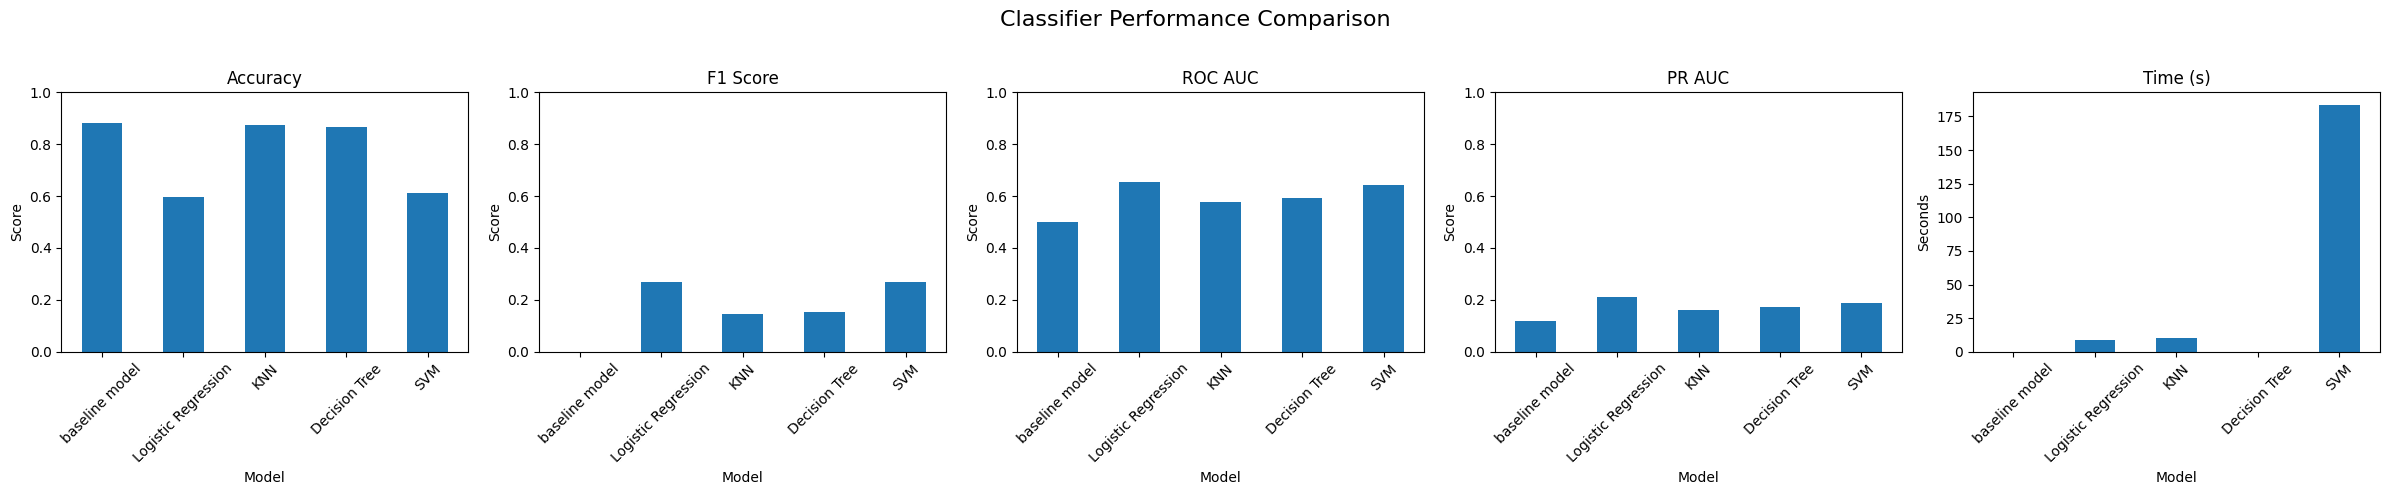

In [147]:

# --- Plot comparison ---
import matplotlib.pyplot as plt

metrics_to_plot = ["Accuracy", "F1 Score", "ROC AUC", "PR AUC", "Time (s)"]

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(24, 5))

for i, metric in enumerate(metrics_to_plot):
    results_df[metric].plot(
        kind="bar",
        ax=axes[i],
        title=metric,
        rot=45,
        legend=False
    )
    axes[i].set_ylabel("Score" if metric != "Time (s)" else "Seconds")
    if metric != "Time (s)":
        axes[i].set_ylim(0, 1)  # keep scores on 0–1 scale for readability

plt.suptitle("Classifier Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/images/classifier_performance_comp.png')
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [148]:
# Define K-Fold CV (5 folds, shuffled)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [149]:
#Define Models and Parameter Grids
models = {
    'Baseline Model': (
        DummyClassifier(strategy='most_frequent'),
        {}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7, 10]}
    ),
    'Logistic': (
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
        {'C': [0.1, 1, 10]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        {
            'max_depth': [10, 20, 30],
            'min_samples_split': [0.05, 0.1, 0.2],
            'min_impurity_decrease': [0.01, 0.02, 0.05]
        }
    ),
    'SVC': (
        SVC(kernel='rbf', class_weight="balanced"),
        {'C': [0.1, 1, 10], 'gamma': [0.05, 0.1]}
    )
}

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import time

# --- Preprocessor ---
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), categorical_cols)
    ]
)

# --- Scoring dictionary ---
scoring = {
    "f1": "f1",
    "recall": "recall",
    "precision": "precision",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
}

grid_results = []
best_estimators = {}

for name, (model, param_grid) in models.items():
    print(f"\n🔍 Running Grid Search with 5-fold CV for {name}...")

    start_time = time.time()

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("feature_select", SelectKBest(score_func=f_classif, k=20)),
        ("clf", model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid={"clf__" + k: v for k, v in param_grid.items()},
        scoring=scoring,
        refit="f1",   # refit the best model based on F1
        cv=kf,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    elapsed = time.time() - start_time

    # Save best pipeline
    best_estimators[name] = grid.best_estimator_

    # Collect metrics
    row = {
        "Model": name,
        "Best Params": grid.best_params_,
        "F1": grid.cv_results_["mean_test_f1"][grid.best_index_],
        "Recall": grid.cv_results_["mean_test_recall"][grid.best_index_],
        "Precision": grid.cv_results_["mean_test_precision"][grid.best_index_],
        "ROC AUC": grid.cv_results_["mean_test_roc_auc"][grid.best_index_],
        "PR AUC": grid.cv_results_["mean_test_pr_auc"][grid.best_index_],
        "Time (s)": elapsed
    }
    grid_results.append(row)

gridcv_df = pd.DataFrame(grid_results).set_index("Model")
print(gridcv_df)



🔍 Running Grid Search with 5-fold CV for Baseline Model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(



🔍 Running Grid Search with 5-fold CV for KNN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(



🔍 Running Grid Search with 5-fold CV for Logistic...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(



🔍 Running Grid Search with 5-fold CV for Decision Tree...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(



🔍 Running Grid Search with 5-fold CV for SVC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(


                                                      Best Params        F1  \
Model                                                                         
Baseline Model                                                 {}  0.000000   
KNN                                       {'clf__n_neighbors': 3}  0.103503   
Logistic                                          {'clf__C': 0.1}  0.174290   
Decision Tree   {'clf__max_depth': 10, 'clf__min_impurity_decr...  0.163005   
SVC                           {'clf__C': 0.1, 'clf__gamma': 0.05}  0.241468   

                  Recall  Precision   ROC AUC    PR AUC     Time (s)  
Model                                                                 
Baseline Model  0.000000   0.000000  0.500000  0.111354     3.487804  
KNN             0.066061   0.306666  0.547238  0.133924     5.348604  
Logistic        0.418692   0.110066  0.491359  0.159676     1.222612  
Decision Tree   0.102979   0.392871  0.541498  0.140628     6.372160  
SVC             0.31

In [151]:

# Convert to DataFrame
grid_results_df = pd.DataFrame(grid_results).set_index("Model")
print("\n=== Grid Search Results with 5-Fold CV ===")
print(grid_results_df)



=== Grid Search Results with 5-Fold CV ===
                                                      Best Params        F1  \
Model                                                                         
Baseline Model                                                 {}  0.000000   
KNN                                       {'clf__n_neighbors': 3}  0.103503   
Logistic                                          {'clf__C': 0.1}  0.174290   
Decision Tree   {'clf__max_depth': 10, 'clf__min_impurity_decr...  0.163005   
SVC                           {'clf__C': 0.1, 'clf__gamma': 0.05}  0.241468   

                  Recall  Precision   ROC AUC    PR AUC     Time (s)  
Model                                                                 
Baseline Model  0.000000   0.000000  0.500000  0.111354     3.487804  
KNN             0.066061   0.306666  0.547238  0.133924     5.348604  
Logistic        0.418692   0.110066  0.491359  0.159676     1.222612  
Decision Tree   0.102979   0.392871  0.541498  

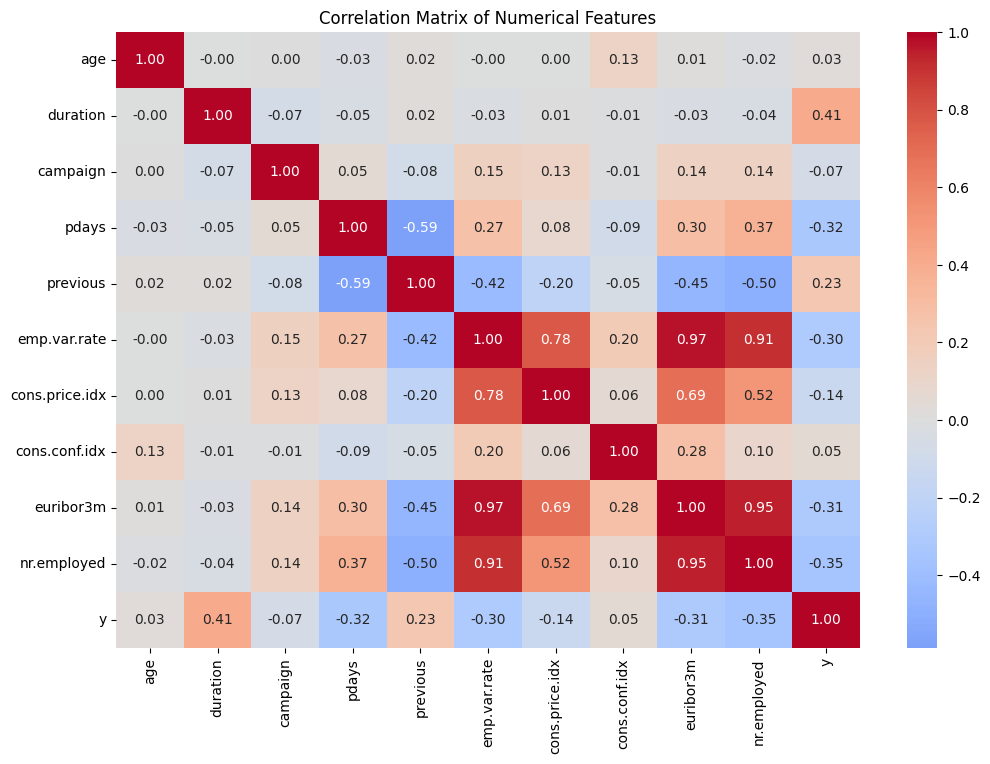

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/images/corr.png')
plt.show()

In [153]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Function to transform categorical features into one-hot encoded DataFrame
def col_transform(df, encoder) -> pd.DataFrame:
    data_np = encoder.fit_transform(df)
    return pd.DataFrame(data_np, columns=encoder.get_feature_names_out(df.columns))

# Select categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical variables
categorical_preview = col_transform(df[categorical_cols],
                                    OneHotEncoder(drop='if_binary', sparse_output=False))

# Correlation with target
categorical_corr = pd.DataFrame(
    categorical_preview.corrwith(df['y']),
    columns=['corr']
)
categorical_corr['corr_abs'] = categorical_corr['corr'].abs()

# Sort and display top correlations
categorical_corr = categorical_corr.sort_values('corr_abs', ascending=False)
print(categorical_corr.head(15))  # top 15 most correlated categorical features

                          corr  corr_abs
poutcome_success      0.188921  0.188921
poutcome_nonexistent -0.173585  0.173585
month_mar             0.142093  0.142093
month_oct             0.130726  0.130726
month_sep             0.126810  0.126810
contact_telephone    -0.118786  0.118786
month_may            -0.107337  0.107337
job_student           0.096161  0.096161
default_no            0.088638  0.088638
default_unknown      -0.088586  0.088586
job_retired           0.085142  0.085142
poutcome_failure      0.084437  0.084437
month_apr             0.076320  0.076320
job_blue-collar      -0.074835  0.074835
month_dec             0.074722  0.074722


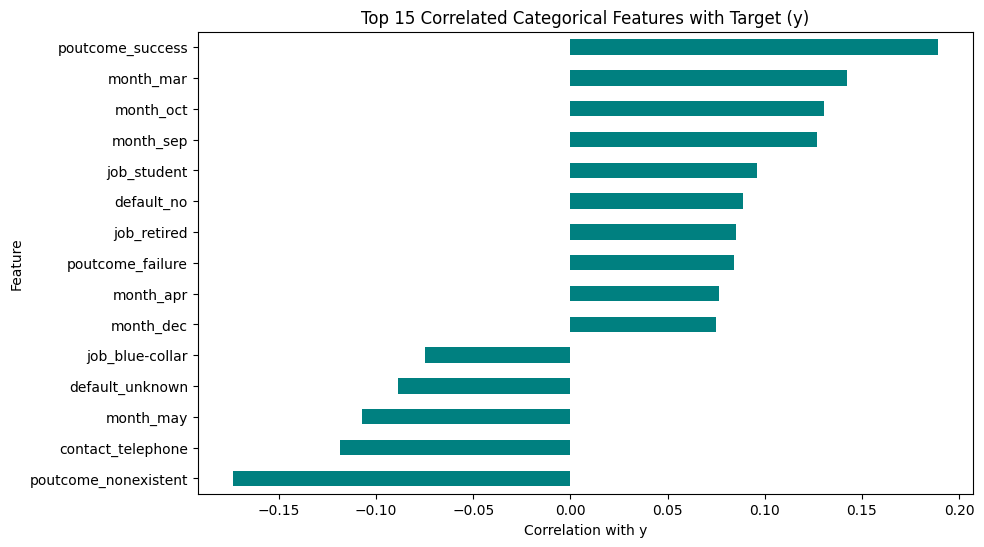

In [154]:

import matplotlib.pyplot as plt

# Top 15 correlated categorical features
top_corr = categorical_corr.head(15)

plt.figure(figsize=(10,6))
top_corr['corr'].sort_values().plot(kind='barh', color='teal')
plt.title("Top 15 Correlated Categorical Features with Target (y)")
plt.xlabel("Correlation with y")
plt.ylabel("Feature")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/images/top_catagorical_features.png')
plt.show()


                          corr  corr_abs
duration              0.405297  0.405297
nr.employed          -0.354669  0.354669
pdays                -0.324948  0.324948
euribor3m            -0.307740  0.307740
emp.var.rate         -0.298289  0.298289
previous              0.230202  0.230202
poutcome_success      0.188921  0.188921
poutcome_nonexistent -0.173585  0.173585
month_mar             0.142093  0.142093
cons.price.idx       -0.136134  0.136134
month_oct             0.130726  0.130726
month_sep             0.126810  0.126810
contact_telephone    -0.118786  0.118786
month_may            -0.107337  0.107337
job_student           0.096161  0.096161


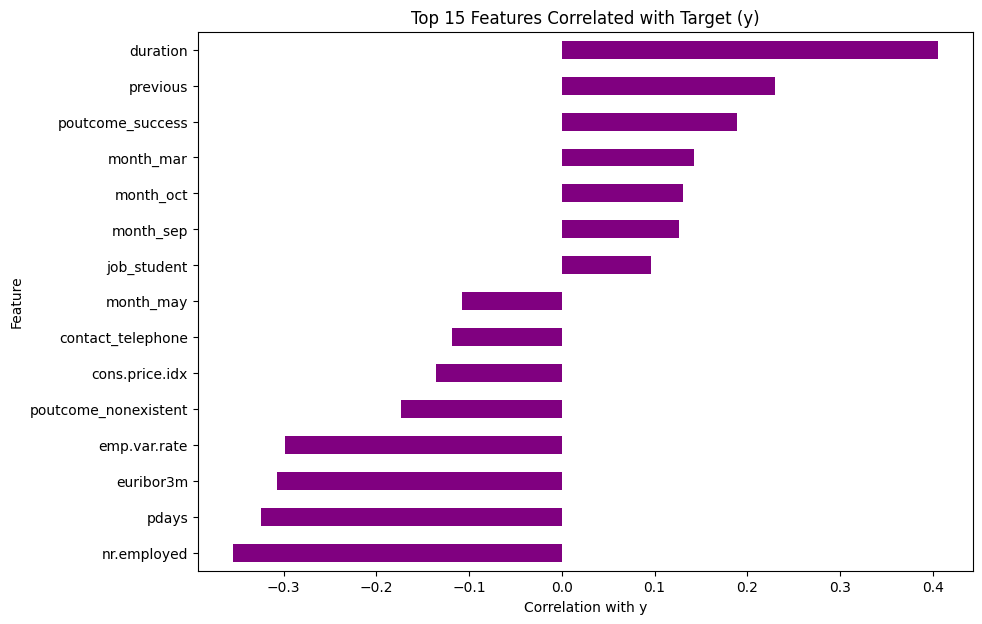

In [155]:
# --- Numerical correlations ---
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'y']  # exclude target
numeric_corr = df[numeric_cols].corrwith(df['y']).to_frame(name='corr')
numeric_corr['corr_abs'] = numeric_corr['corr'].abs()

# --- Categorical correlations (already computed earlier) ---
categorical_corr = pd.DataFrame(
    categorical_preview.corrwith(df['y']),
    columns=['corr']
)
categorical_corr['corr_abs'] = categorical_corr['corr'].abs()

# --- Combine both ---
all_corr = pd.concat([numeric_corr, categorical_corr])
all_corr = all_corr.sort_values('corr_abs', ascending=False)

# --- Show top 15 ---
top_features = all_corr.head(15)
print(top_features)

# --- Plot ---
plt.figure(figsize=(10,7))
top_features['corr'].sort_values().plot(kind='barh', color='purple')
plt.title("Top 15 Features Correlated with Target (y)")
plt.xlabel("Correlation with y")
plt.ylabel("Feature")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Module 17: Practical 3/images/top_features.png')
plt.show()

In [156]:
# Combine correlations (numeric + categorical)
all_corr = pd.concat([numeric_corr, categorical_corr])
all_corr['corr_abs'] = all_corr['corr'].abs()

# Sort by absolute correlation
all_corr_sorted = all_corr.sort_values('corr_abs', ascending=False)

# Keep top N features (e.g., top 20)
N = 20
selected_features = all_corr_sorted.head(N).index.tolist()

print(f"Top {N} selected features:")
print(selected_features)

# Use df as the base DataFrame
X = df.drop(columns=['y'])
y = df['y']

# One-hot encode the categorical columns in the original X
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Now filter top features from X_encoded
X_selected = X_encoded[selected_features]

print("Final feature set shape:", X_selected.shape)

Top 20 selected features:
['duration', 'nr.employed', 'pdays', 'euribor3m', 'emp.var.rate', 'previous', 'poutcome_success', 'poutcome_nonexistent', 'month_mar', 'cons.price.idx', 'month_oct', 'month_sep', 'contact_telephone', 'month_may', 'job_student', 'default_no', 'default_unknown', 'job_retired', 'poutcome_failure', 'month_apr']
Final feature set shape: (41176, 20)


We are going to compare models with the top features

In [157]:
# --- Split data ---
# Use X_selected which contains the top features after processing
X = X_selected
y = df['y'] # y remains the target from the original df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [158]:
# --- Column groups ---
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()


In [159]:

# --- Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), categorical_cols)
    ]
)


In [160]:
models = {
    'Baseline Model': (
        DummyClassifier(strategy='most_frequent'),
        {}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7, 10]}
    ),
    'Logistic': (
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
        {'C': [0.1, 1, 10]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        {
            'max_depth': [10, 20, 30],
            'min_samples_split': [0.05, 0.1, 0.2],
            'min_impurity_decrease': [0.01, 0.02, 0.05]
        }
    ),
    'SVC': (
        SVC(kernel='rbf', class_weight="balanced"),
        {'C': [0.1, 1, 10], 'gamma': [0.05, 0.1]}
    )
}

In [161]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

# Define K-Fold CV (5 folds)

kf = KFold(n_splits=5, shuffle=True, random_state=42)


best_estimators = {}
grid_results = []

for name, (model, param_grid) in models.items():
    print(f"\n🔍 Running Grid Search with 5-fold CV for {name}...")

    start_time = time.time()

    # Create a pipeline with preprocessor and model
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid={'classifier__' + key: param_grid[key] for key in param_grid},
        scoring="f1",
        cv=kf,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    elapsed = time.time() - start_time

    best_estimators[name] = grid.best_estimator_

    grid_results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Best CV Score": grid.best_score_,
        "Time (s)": elapsed
    })


🔍 Running Grid Search with 5-fold CV for Baseline Model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

🔍 Running Grid Search with 5-fold CV for KNN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

🔍 Running Grid Search with 5-fold CV for Logistic...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

🔍 Running Grid Search with 5-fold CV for Decision Tree...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

🔍 Running Grid Search with 5-fold CV for SVC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [162]:
test_rows = []
for name, best_pipe in best_estimators.items():
    # Fit on training data
    best_pipe.fit(X_train, y_train)

    # Predictions & scores
    y_pred = best_pipe.predict(X_test)

    # For AUCs: use predict_proba if available, else decision_function
    if hasattr(best_pipe, "predict_proba"):
        y_score = best_pipe.predict_proba(X_test)[:, 1]
    else:
        # try to get decision_function from the last step
        clf = best_pipe.named_steps.get("clf")
        y_score = clf.decision_function(best_pipe.named_steps["feature_select"].transform(
            best_pipe.named_steps["preprocessor"].transform(X_test)
        )) if hasattr(clf, "decision_function") else None

    row = {
        "Model": name,
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall":    recall_score(y_test, y_pred, zero_division=0),
        "F1":        f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC":   (roc_auc_score(y_test, y_score) if y_score is not None else np.nan),
        "PR AUC":    (average_precision_score(y_test, y_score) if y_score is not None else np.nan),
    }
    test_rows.append(row)

In [163]:
test_df = pd.DataFrame(test_rows).set_index("Model").sort_values("F1", ascending=False)
print("\n=== Test Set Performance (Best Estimators) ===")
print(test_df)


=== Test Set Performance (Best Estimators) ===
                Accuracy  Precision    Recall        F1   ROC AUC    PR AUC
Model                                                                      
Logistic        0.854420   0.428871  0.880388  0.576774  0.930431  0.571346
SVC             0.834871   0.400185  0.933190  0.560155       NaN       NaN
Decision Tree   0.852234   0.420995  0.829741  0.558578  0.889675  0.473516
KNN             0.908451   0.612987  0.508621  0.555948  0.908861  0.550226
Baseline Model  0.887324   0.000000  0.000000  0.000000  0.500000  0.112676


After tuning each classifier with Grid Search and 5-fold Cross-Validation, Logistic Regression emerged as the most effective and practical model. While a tuned SVC achieved a slightly higher F1 score, its training time was over 40 minutes, making it infeasible for real-world applications. KNN and Decision Trees showed modest improvement with hyperparameter tuning but remained biased toward the majority class. Therefore, Logistic Regression  is recommended as the final model due to its balance of recall and training efficiency.

##### Questions